<a href="https://colab.research.google.com/github/ajsal-ali/Portfolio-optimization/blob/main/portfolio_optimisation_using_garch_copula_markovitz_method_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas scipy arch copulas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from arch import arch_model
import copulas
from copulas.univariate import GaussianKDE
from copulas.bivariate import Clayton
from copulas.multivariate import VineCopula
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis
from scipy import interpolate
from scipy.special import ndtr
from scipy.stats import norm, gaussian_kde
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from copulas.multivariate import VineCopula
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import GaussianKDE
import seaborn as sns


In [ ]:

# Define tickers and date range
tickers = ['MSFT', 'BA', 'V', 'PA=F', 'HG=F', 'GC=F', 'CL=F', 'KER.PA', 'AAPL', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2018-01-01'
end_date = '2024-12-31'

trad_data = yf.download(tickers, start=start_date, end=end_date,interval='1d')['Close']

/tmp/ipython-input-3-851081981.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  trad_data = yf.download(tickers, start=start_date, end=end_date,interval='1d')['Close']
[*********************100%***********************]  12 of 12 completed


In [ ]:
tickers = ['PIVX-USD', 'ETH-USD', 'XRP-USD', 'XVG-USD', 'UNO-USD', 'BTC-USD']
start_date = '2018-01-01'
end_date = '2024-12-31'

data_crypto = yf.download(tickers, start=start_date, end=end_date,interval='1d')['Close']

/tmp/ipython-input-4-124074003.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_crypto = yf.download(tickers, start=start_date, end=end_date,interval='1d')['Close']
[*********************100%***********************]  6 of 6 completed


In [ ]:
crypto_returns = (np.log(data_crypto / data_crypto.shift(1)) * 100).dropna()
trad_returns = (np.log(trad_data / trad_data.shift(1)) * 100).dropna()
crypto_returns = crypto_returns.clip(lower=-60, upper=60)
trad_returns = trad_returns.clip(lower=-60, upper=60)
crypto_returns = crypto_returns.dropna()
trad_returns = trad_returns.dropna()

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [ ]:
crypto_returns = (data_crypto / data_crypto.shift(1) - 1) * 100
trad_returns = (trad_data / trad_data.shift(1) - 1) * 100
crypto_returns = crypto_returns.dropna()
trad_returns = trad_returns.dropna()
crypto_returns = crypto_returns.clip(lower=-60, upper=60)
trad_returns = trad_returns.clip(lower=-60, upper=60)

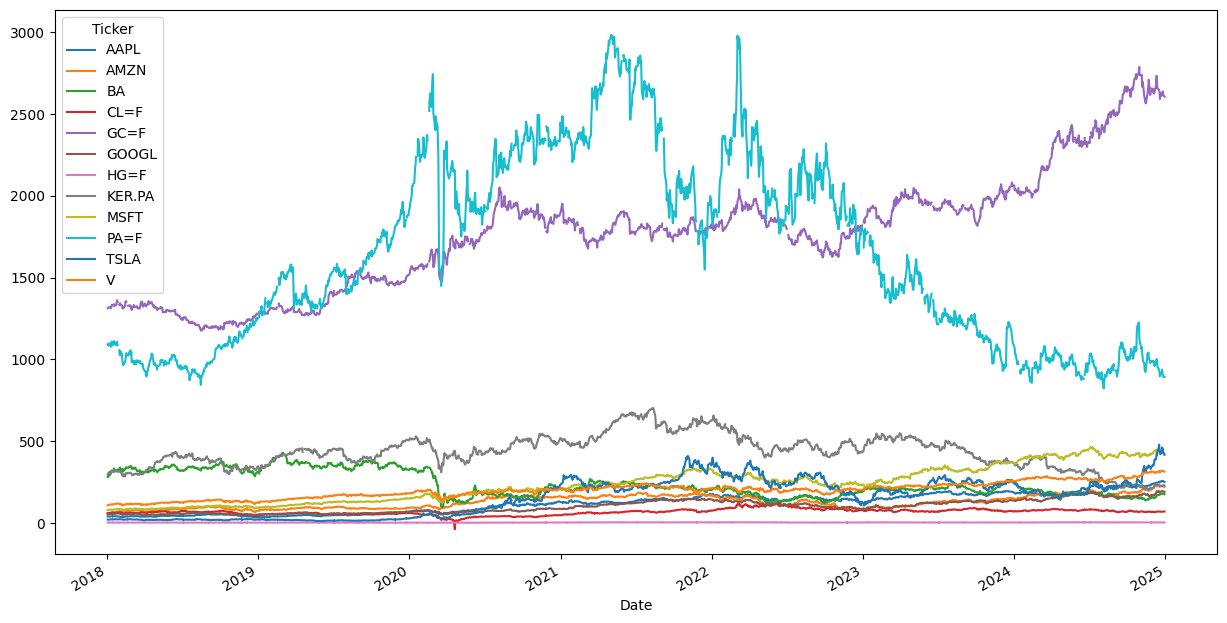

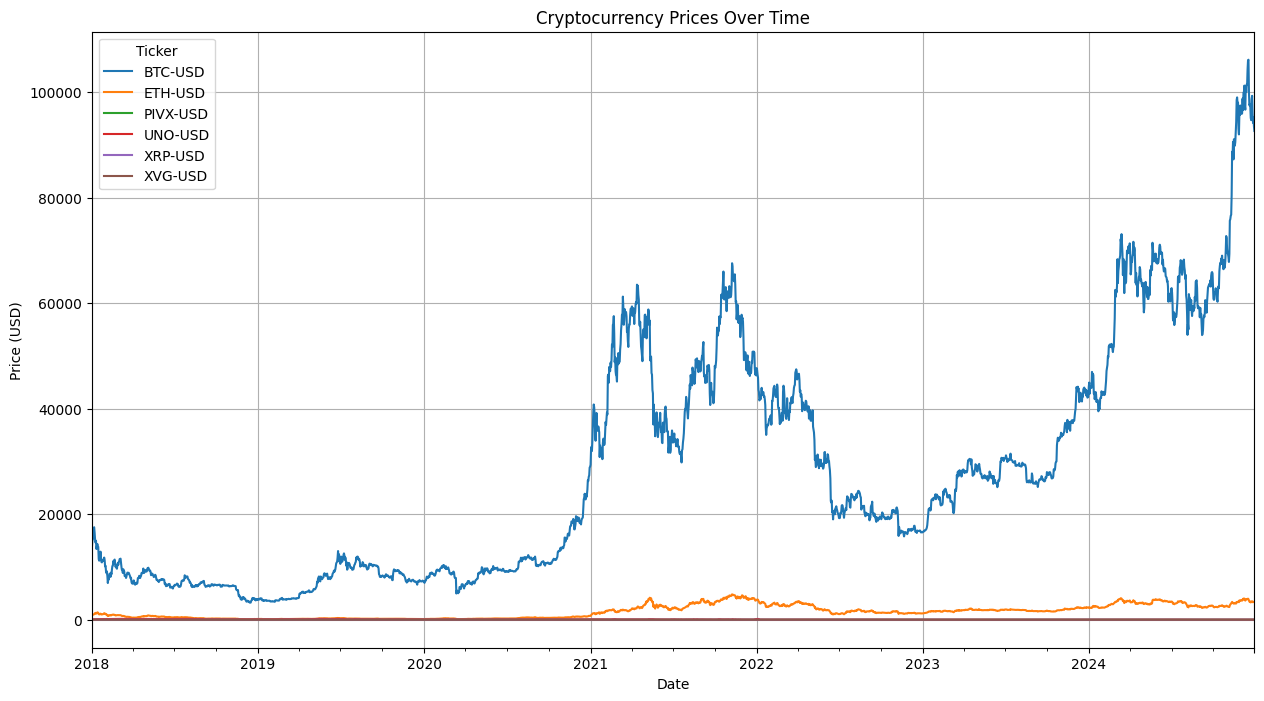

In [ ]:
trad_data.plot(figsize=(15, 8))

data_crypto.plot(figsize=(15, 8))
plt.title('Cryptocurrency Prices Over Time')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

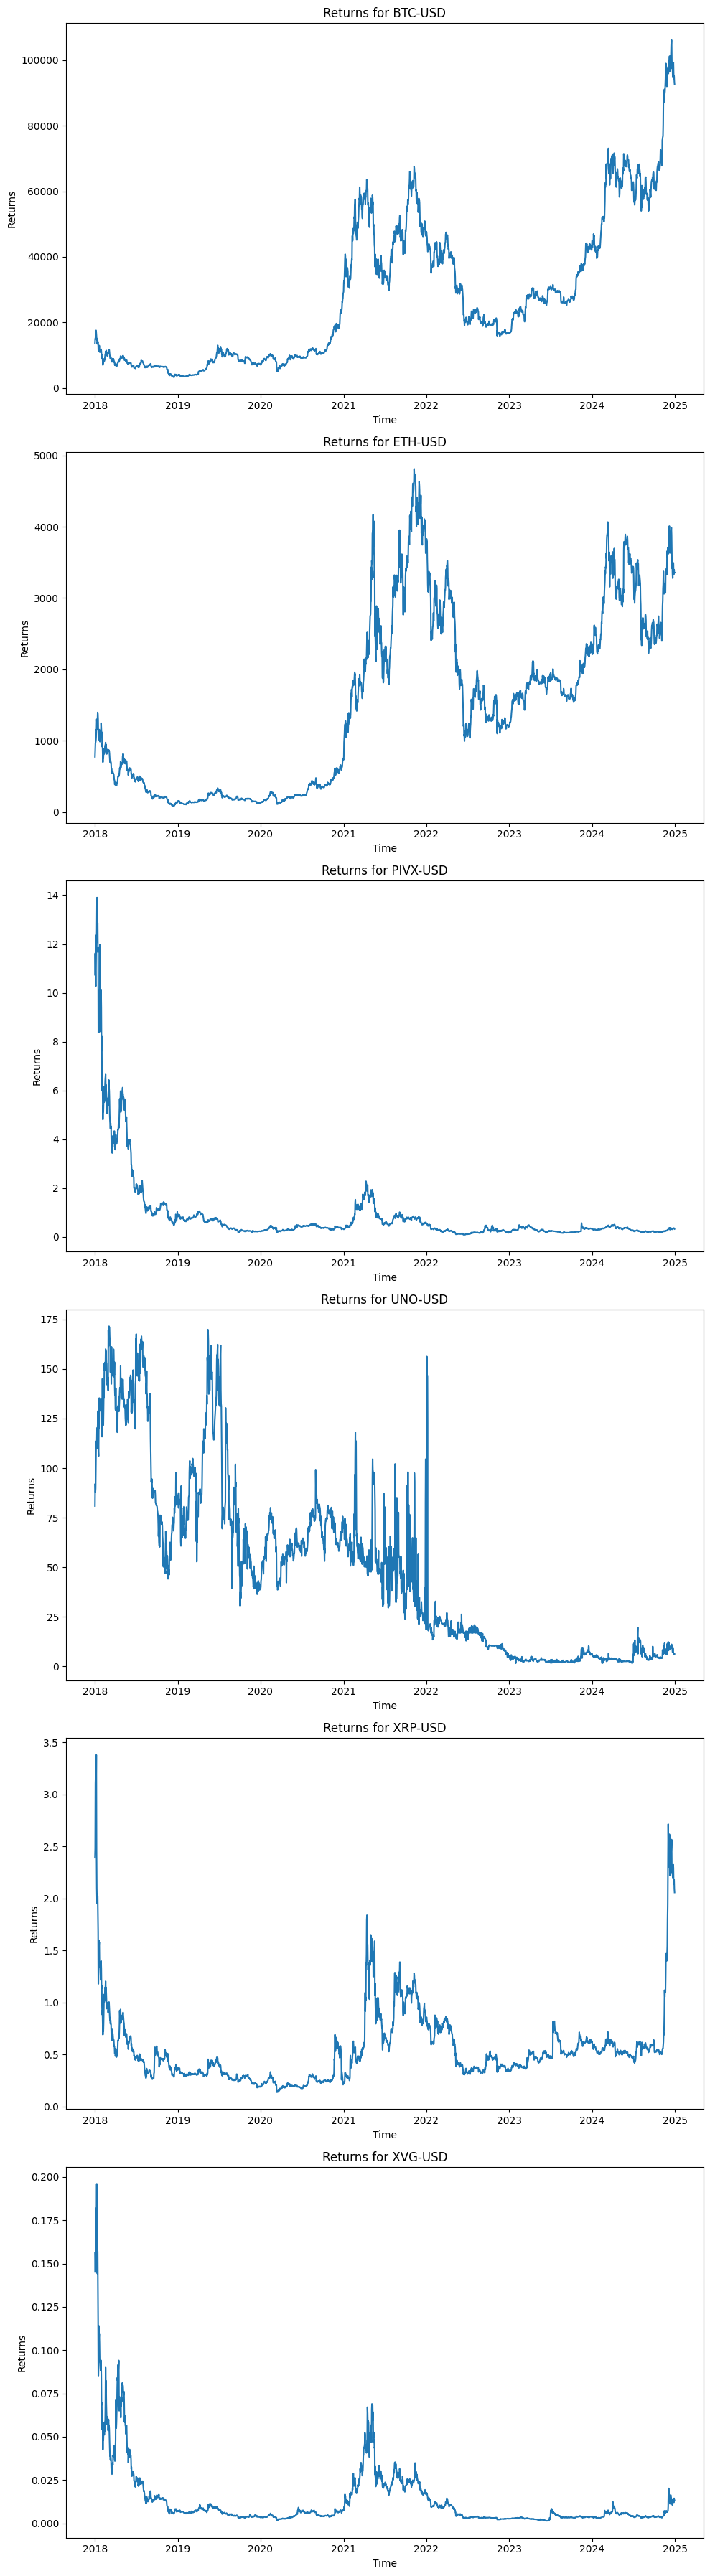

In [ ]:
fig, axes = plt.subplots(len(data_crypto.columns), 1, figsize=(10, 6 * len(data_crypto.columns)))  # Create subplots

# Iterate through columns and plot on respective axes
for i, col in enumerate(data_crypto.columns):
    axes[i].plot(data_crypto[col])
    axes[i].set_title(f"Returns for {col}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Returns")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

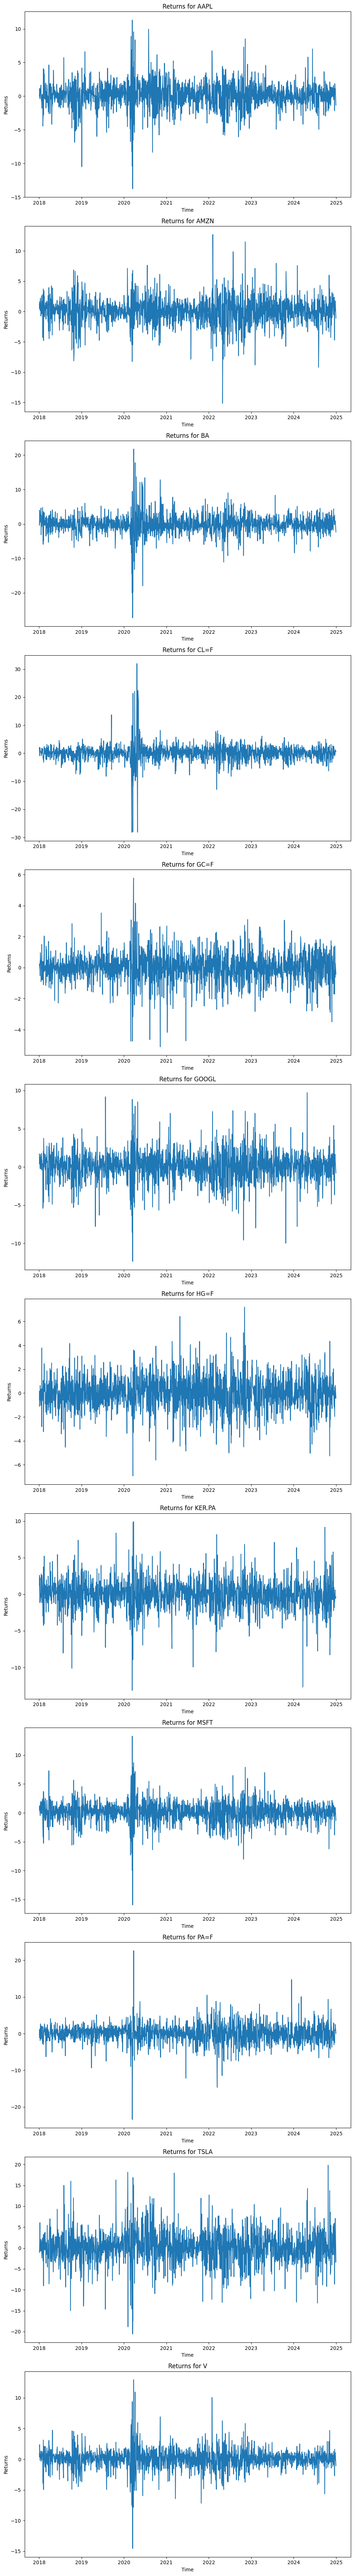

In [ ]:
fig, axes = plt.subplots(len(trad_returns.columns), 1, figsize=(10, 6 * len(trad_returns.columns)))  # Create subplots

# Iterate through columns and plot on respective axes
for i, col in enumerate(trad_returns.columns):
    axes[i].plot(trad_returns[col])
    axes[i].set_title(f"Returns for {col}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Returns")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [ ]:
def find_best_garch_model(data):
    best_aic = np.inf
    best_p, best_q = 0, 0
    best_model = None

    for p in range(1, 6):
        for q in range(1, 6):
            try:
                model = arch_model(data, vol="Garch", p=p, q=q, dist="normal")
                res = model.fit(disp="off")

                if res.aic < best_aic:
                    best_aic = res.aic
                    best_p, best_q = p, q
                    best_model = res
            except:
                continue

    return best_p, best_q

In [ ]:
for col in crypto_returns.columns:
    p, q = find_best_garch_model(crypto_returns[col].dropna())
    print(f"Best GARCH Model for {col}: p={p}, q={q}")

Best GARCH Model for BTC-USD: p=3, q=5
Best GARCH Model for ETH-USD: p=3, q=5
Best GARCH Model for PIVX-USD: p=5, q=3
Best GARCH Model for UNO-USD: p=1, q=5
Best GARCH Model for XRP-USD: p=5, q=4
Best GARCH Model for XVG-USD: p=1, q=1


In [ ]:
for col in trad_returns.columns:
    p, q = find_best_garch_model(trad_returns[col])
    print(f"Best GARCH Model for {col}: p={p}, q={q}")

Best GARCH Model for AAPL: p=1, q=1
Best GARCH Model for AMZN: p=1, q=1
Best GARCH Model for BA: p=1, q=1
Best GARCH Model for CL=F: p=1, q=2
Best GARCH Model for GC=F: p=4, q=3
Best GARCH Model for GOOGL: p=1, q=2
Best GARCH Model for HG=F: p=1, q=2
Best GARCH Model for KER.PA: p=1, q=1
Best GARCH Model for MSFT: p=1, q=1
Best GARCH Model for PA=F: p=1, q=3
Best GARCH Model for TSLA: p=1, q=1
Best GARCH Model for V: p=2, q=3


In [ ]:
def fit_garch_models(data):
    garch_models = {}
    residuals = {}
    for col in data.columns:
        # p, q = find_best_garch_model(data[col].dropna())
        # print(f"Best GARCH Model for {col}: p={p}, q={q}")
        model = arch_model(data[col], mean="ARX", lags=1, vol="Garch", p=1, q=1, dist="normal")

        res = model.fit(disp="off")
        garch_models[col] = res
        residuals[col] = res.resid / res.conditional_volatility
    return garch_models, pd.DataFrame(residuals)

In [ ]:
reconstructed_data = first_column_inverse_function(first_column_uniform)


NameError: name 'first_column_inverse_function' is not defined

In [ ]:
def transform_residuals(residuals):
    uniform_data = {}
    inverse_functions = {}

    for col in residuals.columns:
        # Fit KDE to residuals
        kde = GaussianKDE()
        kde.fit(residuals[col].values)

        # Compute the CDF for the residuals
        cdf_values = kde.cumulative_distribution(residuals[col].values)

        # Store uniform-transformed data
        uniform_data[col] = cdf_values

        # Create the inverse function (interpolation)
        sorted_residuals = np.sort(residuals[col].values)
        inverse_function = interpolate.interp1d(cdf_values, sorted_residuals, kind='linear', bounds_error=False,  fill_value="extrapolate" )
        inverse_functions[col] = inverse_function

    return pd.DataFrame(uniform_data), inverse_functions


In [ ]:
def fit_r_vine_copula(data):
    vine = VineCopula('regular')
    vine.fit(data)
    return vine
def fit_c_vine_copula(data):
    vine = VineCopula('center')
    vine.fit(data)
    return vine
def fit_d_vine_copula(data):
    vine = VineCopula('direct')
    vine.fit(data)
    return vine
def fit_t_copula(data):
    copula = GaussianMultivariate()
    copula.fit(data)
    return copula


Fit different copula and optimise


In [ ]:
def portfolio_optimization(cov_matrix, expected_returns):
    n_assets = len(expected_returns)

    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_volatility  # Maximize Sharpe Ratio

    constraints = ({"type": "eq", "fun": lambda weights: np.sum(weights) - 1})
    bounds = [(0, 0.4) for _ in range(n_assets)] # set max weight to 40% for each asset

    initial_weights = np.ones(n_assets) / n_assets
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result.x

In [ ]:
def garchcopulaopt(rolling_returns, n):
    # Fit GARCH models to the rolling returns data and get residuals
    garch_models, residuals = fit_garch_models(rolling_returns)

    residuals = residuals.dropna()

    # Transform residuals to uniform data using CDF
    uniform_data_tcopula, inverse_functions_tcopula = transform_residuals(residuals)

    # Add a check for NaNs after transformation
    if uniform_data_tcopula.isnull().sum().sum() > 0:
        print("NaNs found in uniform_data_tcopula after transformation.")
        # Handle NaNs if necessary, e.g., drop rows with NaNs
        uniform_data_tcopula = uniform_data_tcopula.dropna()
        print(f"Shape of uniform_data_tcopula after dropping NaNs: {uniform_data_tcopula.shape}")


    #  Fit and simulate copulas
    copula_rvine = fit_r_vine_copula(uniform_data_tcopula)
    copula_cvine = fit_c_vine_copula(uniform_data_tcopula)
    copula_dvine = fit_d_vine_copula(uniform_data_tcopula)

    # Simulate data for each copula
    simulated_data_rvine = copula_rvine.sample(n)
    simulated_data_cvine = copula_cvine.sample(n)
    simulated_data_dvine = copula_dvine.sample(n)

    # Simulate residuals for each copula
    simulated_residuals_rvine = {}
    simulated_residuals_cvine = {}
    simulated_residuals_dvine = {}

    # Get the residuals from the uniform simulated data using inverse of CDF
    for col in simulated_data_rvine.columns:
        # Using inverse functions to obtain standardized residuals
        simulated_residuals_rvine[col] = inverse_functions_tcopula[col](simulated_data_rvine[col])
        simulated_residuals_cvine[col] = inverse_functions_tcopula[col](simulated_data_cvine[col])
        simulated_residuals_dvine[col] = inverse_functions_tcopula[col](simulated_data_dvine[col])

    forecasted_data_rvine = {}
    forecasted_data_cvine = {}
    forecasted_data_dvine = {}

    for col in garch_models.keys():
        # Get the forecasted mean and volatility for each asset
        forecast_mean = garch_models[col].forecast(horizon=n).mean.iloc[-1]
        forecast_volatility = np.sqrt(garch_models[col].forecast(horizon=n).variance.iloc[-1])

        # Generate simulated shocks (residuals) for the next n days
        simulated_shocks = np.random.normal(0, forecast_volatility, size=n)

        # Simulate the returns for the next n days by adding forecasted mean and standardized residuals scaled by volatility
        forecasted_data_rvine[col] = forecast_mean +  simulated_residuals_rvine[col]*forecast_volatility
        forecasted_data_cvine[col] = forecast_mean + simulated_residuals_cvine[col]*forecast_volatility
        forecasted_data_dvine[col] = forecast_mean +  simulated_residuals_dvine[col] * forecast_volatility

    # Calculate the covariance matrices for the simulated data
    simulated_returns_rvine = pd.DataFrame(forecasted_data_rvine)
    simulated_returns_cvine = pd.DataFrame(forecasted_data_cvine)
    simulated_returns_dvine = pd.DataFrame(forecasted_data_dvine)

    cov_matrix_rvine = simulated_returns_rvine.cov()
    cov_matrix_cvine = simulated_returns_cvine.cov()
    cov_matrix_dvine = simulated_returns_dvine.cov()

    # Calculate expected returns as the average of the forecasted data
    expected_returns_rvine = simulated_returns_rvine.mean()
    expected_returns_cvine = simulated_returns_cvine.mean()
    expected_returns_dvine = simulated_returns_dvine.mean()

    # Step Perform portfolio optimization for each copula and find optimal weights
    weights_rvine = portfolio_optimization(cov_matrix_rvine, expected_returns_rvine)
    weights_cvine = portfolio_optimization(cov_matrix_cvine, expected_returns_cvine)
    weights_dvine = portfolio_optimization(cov_matrix_dvine, expected_returns_dvine)

    # Return the weights for all three copulas
    return {
        'R-Vine': weights_rvine,
        'C-Vine': weights_cvine,
        'D-Vine': weights_dvine
    }

def garchcopulaopt_rolling(assets, n):
    # dictionary to store weights for each rolling window
    # all_weights = {'R-Vine': [], 'C-Vine': [], 'D-Vine': [], 'T-Copula': []}
    all_weights = {'R-Vine': [], 'C-Vine': [], 'D-Vine': []}

    # Iterate over the rolling windows of size n
    for start in range(0, len(assets) - n + 1, n):

        rolling_window = assets.iloc[start:start + n]

        # Check if the rolling window is empty or contains only NaNs
        if rolling_window.dropna().empty:
            print(f"Skipping window starting at index {start} due to empty or all NaN data.")
            continue


        # Get the weights for this window using the multi-copula function
        weights = garchcopulaopt(rolling_window, n)
        for copula_type in all_weights:
            all_weights[copula_type].append(weights[copula_type])

    # Convert the list of weights into a DataFrame
    weights_df = {}
    for copula_type in all_weights:
        weights_df[copula_type] = pd.DataFrame(all_weights[copula_type])

    return weights_df

In [ ]:
# def garchcopulaopt(rolling_returns, n):
#     # Fit GARCH models to the rolling returns data and get residuals
#     garch_models, residuals = fit_garch_models(rolling_returns)
#     # print(residuals.isnull().sum())
#     residuals = residuals.dropna()

#     # Transform residuals to uniform data using CDF
#     # uniform_data_rvine, inverse_functions_rvine = transform_residuals(residuals)
#     # uniform_data_cvine, inverse_functions_cvine = transform_residuals(residuals)
#     # uniform_data_dvine, inverse_functions_dvine = transform_residuals(residuals)
#     uniform_data_tcopula, inverse_functions_tcopula = transform_residuals(residuals)

#     #  Fit and simulate copulas
#     copula_rvine = fit_r_vine_copula(uniform_data_tcopula)
#     copula_cvine = fit_c_vine_copula(uniform_data_tcopula)
#     copula_dvine = fit_d_vine_copula(uniform_data_tcopula)
#     # copula_tcopula = fit_t_copula(uniform_data_tcopula)

#     # Simulate data for each copula
#     simulated_data_rvine = copula_rvine.sample(n)
#     simulated_data_cvine = copula_cvine.sample(n)
#     simulated_data_dvine = copula_dvine.sample(n)
#     # simulated_data_tcopula = copula_tcopula.sample(n)

#     # Step 5: Simulate residuals for each copula
#     simulated_residuals_rvine = {}
#     simulated_residuals_cvine = {}
#     simulated_residuals_dvine = {}
#     # simulated_residuals_tcopula = {}
#     # get the residuals from the uniform simulated data using inverse of CDF

#     for col in simulated_data_rvine.columns:
#         simulated_residuals_rvine[col] = inverse_functions_tcopula[col](simulated_data_rvine[col])
#         simulated_residuals_cvine[col] = inverse_functions_tcopula[col](simulated_data_cvine[col])
#         simulated_residuals_dvine[col] = inverse_functions_tcopula[col](simulated_data_dvine[col])
#         # simulated_residuals_tcopula[col] = inverse_functions_tcopula[col](simulated_data_tcopula[col])


#     forecasted_data_rvine = {}
#     forecasted_data_cvine = {}
#     forecasted_data_dvine = {}
#     # forecasted_data_tcopula = {}

#     for col in garch_models.keys():
#         # Get the forecasted mean and volatility for each asset
#         forecast_mean = garch_models[col].forecast(horizon=n).mean.iloc[-1]
#         forecast_volatility = np.sqrt(garch_models[col].forecast(horizon=n).variance.iloc[-1])

#         # Generate simulated shocks (residuals) for the next n days
#         simulated_shocks = np.random.normal(0, forecast_volatility, size=n)

#         # Simulate the returns for the next n days by adding forecasted mean to shocks and simulated residuals
#         forecasted_data_rvine[col] = forecast_mean + simulated_shocks + simulated_residuals_rvine[col]
#         forecasted_data_cvine[col] = forecast_mean + simulated_shocks + simulated_residuals_cvine[col]
#         forecasted_data_dvine[col] = forecast_mean + simulated_shocks + simulated_residuals_dvine[col]
#         # forecasted_data_tcopula[col] = forecast_mean + simulated_shocks + simulated_residuals_tcopula[col]

#     # Calculate the covariance matrices for the simulated data
#     simulated_returns_rvine = pd.DataFrame(forecasted_data_rvine)
#     simulated_returns_cvine = pd.DataFrame(forecasted_data_cvine)
#     simulated_returns_dvine = pd.DataFrame(forecasted_data_dvine)
#     # simulated_returns_tcopula = pd.DataFrame(forecasted_data_tcopula)

#     cov_matrix_rvine = simulated_returns_rvine.cov()
#     cov_matrix_cvine = simulated_returns_cvine.cov()
#     cov_matrix_dvine = simulated_returns_dvine.cov()
#     # cov_matrix_tcopula = simulated_returns_tcopula.cov()

#     # Calculate expected returns as the average of the forecasted data
#     expected_returns_rvine = simulated_returns_rvine.mean()
#     expected_returns_cvine = simulated_returns_cvine.mean()
#     expected_returns_dvine = simulated_returns_dvine.mean()
#     # expected_returns_tcopula = simulated_returns_tcopula.mean()

#     # Step Perform portfolio optimization for each copula and find optimal weights
#     weights_rvine = portfolio_optimization(cov_matrix_rvine, expected_returns_rvine)
#     weights_cvine = portfolio_optimization(cov_matrix_cvine, expected_returns_cvine)
#     weights_dvine = portfolio_optimization(cov_matrix_dvine, expected_returns_dvine)
#     print("Weights from R-Vine:", weights_rvine)


#     # weights_tcopula = portfolio_optimization(cov_matrix_tcopula, expected_returns_tcopula)

#     # Return the weights for all four copulas
#     return {
#         'R-Vine': weights_rvine,
#         'C-Vine': weights_cvine,
#         'D-Vine': weights_dvine,
#         # 'T-Copula': weights_tcopula
#     }

def garchcopulaopt_rolling(assets, n):
    # dictionary to store weights for each rolling window
    # all_weights = {'R-Vine': [], 'C-Vine': [], 'D-Vine': [], 'T-Copula': []}
    all_weights = {'R-Vine': [], 'C-Vine': [], 'D-Vine': []}

    # Iterate over the rolling windows of size n
    for start in range(0, len(assets) - n + 1, n):

        rolling_window = assets.iloc[start:start + n]

        # Get the weights for this window using the multi-copula function
        weights = garchcopulaopt(rolling_window, n)
        for copula_type in all_weights:
            all_weights[copula_type].append(weights[copula_type])

    # Convert the list of weights into a DataFrame
    weights_df = {}
    for copula_type in all_weights:
        weights_df[copula_type] = pd.DataFrame(all_weights[copula_type])

    return weights_df


In [ ]:
def calculate_portfolio_value(weights_df, daily_returns, n, initial_value=1000, risk_free_rate=0.01/252):
    """
    Calculate portfolio value over time using log returns

    Args:
        weights_df: DataFrame of portfolio weights
        daily_returns: DataFrame of asset log returns
        n: Window size
        initial_value: Initial portfolio value
        risk_free_rate: Daily risk-free rate (annual/252)

    Returns:
        portfolio_value: Array of portfolio values
        sharpe_ratio: Sharpe ratio of the portfolio
        max_drawdown: Maximum drawdown of the portfolio
        total_return: Total return of the portfolio
    """
    # Initialize portfolio value array with the initial value
    portfolio_value = np.zeros(daily_returns.shape[0])
    portfolio_value[:n] = initial_value

    # Arrays to store daily portfolio returns
    portfolio_returns = np.zeros(daily_returns.shape[0])

    # Loop through the rolling windows, starting from day n
    for i in range(n, len(daily_returns)):
        weightindex = (i-n) // n
        if weightindex >= len(weights_df):
            weightindex = len(weights_df) - 1

        weights = weights_df.iloc[weightindex]

        # Calculate portfolio log return as weighted sum of asset log returns
        portfolio_return = np.dot(weights, daily_returns.iloc[i])
        portfolio_returns[i] = portfolio_return

        # For log returns, the portfolio value is calculated as:
        # P_t = P_{t-1} * exp(r_t)
        portfolio_value[i] = portfolio_value[i-1] * np.exp(portfolio_return/100)

    # Calculate performance metrics
    # Slice portfolio_returns from n to end to only include actual calculated returns
    actual_returns = portfolio_returns[n:]
    actual_values = portfolio_value[n:]

    # Calculate Sharpe ratio
    excess_returns = actual_returns
    sharpe_ratio = np.mean(excess_returns) / np.std(actual_returns) * np.sqrt(252)  # Annualized

    # Calculate maximum drawdown
    peak = np.maximum.accumulate(actual_values)
    drawdown = (actual_values - peak) / peak
    max_drawdown = np.min(drawdown)

    # Calculate total return
    total_return = (portfolio_value[-1] / portfolio_value[n] - 1) * 100

    return portfolio_value, sharpe_ratio, max_drawdown, total_return

def plot_portfolio_value(weights_df, daily_returns, copula_types, n, sp500_returns=None):
    """
    Plot portfolio value evolution for different copula types and compare with S&P 500
    """
    plt.figure(figsize=(12, 8))

    # Store performance metrics for comparison
    performance = {
        'Portfolio': [],
        'Sharpe Ratio': [],
        'Max Drawdown (%)': [],
        'Total Return (%)': []
    }

    # Iterate through the copula types and plot their portfolio value evolution
    for copula_type in copula_types:
        portfolio_value, sharpe, drawdown, total_return = calculate_portfolio_value(weights_df[copula_type], daily_returns, n)
        # Align portfolio_value with daily_returns index for plotting
        portfolio_value_aligned = pd.Series(portfolio_value, index=daily_returns.index)
        plt.plot(portfolio_value_aligned, label=f"{copula_type}")

        # Store performance metrics
        performance['Portfolio'].append(copula_type)
        performance['Sharpe Ratio'].append(round(sharpe, 2))
        performance['Max Drawdown (%)'].append(round(drawdown * 100, 2))
        performance['Total Return (%)'].append(round(total_return, 2))

    # Add S&P 500 for comparison if provided
    if sp500_returns is not None:
        # Align S&P 500 returns with portfolio returns timeframe
        aligned_sp500 = sp500_returns[daily_returns.index[0]:daily_returns.index[-1]].dropna()

        # Calculate S&P 500 portfolio value
        sp500_value = np.zeros(len(aligned_sp500))
        sp500_value[0] = 1000
        for i in range(1, len(aligned_sp500)):
            sp500_value[i] = sp500_value[i-1] * np.exp(aligned_sp500.iloc[i]/100)

        # Align S&P 500 value with daily_returns index for plotting
        sp500_value_aligned = pd.Series(sp500_value, index=aligned_sp500.index)

        # Plot S&P 500
        plt.plot(sp500_value_aligned.index, sp500_value_aligned, label="S&P 500", linestyle='--')

        # Calculate S&P 500 metrics
        sp500_actual_returns = aligned_sp500.iloc[n:]
        sp500_actual_value = sp500_value_aligned.iloc[n:]

        risk_free_rate = 0.01/252  # 1% annual rate converted to daily
        sp500_excess_returns = sp500_actual_returns - risk_free_rate*100
        sp500_sharpe = np.mean(sp500_excess_returns) / np.std(sp500_actual_returns) * np.sqrt(252)

        peak = np.maximum.accumulate(sp500_actual_value)
        drawdown = (sp500_actual_value - peak) / peak
        sp500_max_drawdown = np.min(drawdown)

        sp500_total_return = (sp500_value_aligned[-1] / sp500_value_aligned[0] - 1) * 100

        # Add S&P 500 metrics to performance table
        performance['Portfolio'].append('S&P 500')
        performance['Sharpe Ratio'].append(round(sp500_sharpe, 2))
        performance['Max Drawdown (%)'].append(round(sp500_max_drawdown * 100, 2))
        performance['Total Return (%)'].append(round(sp500_total_return, 2))

    plt.title("Portfolio Value Evolution")
    plt.xlabel("Time")
    plt.ylabel("Portfolio Value")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Display performance metrics
    perf_df = pd.DataFrame(performance)
    display(perf_df.set_index('Portfolio'))

    return perf_df

In [ ]:
n=30

In [ ]:
weights=garchcopulaopt_rolling(trad_returns,n)


/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:78: UserWarning: Vines have not been fully tested on Python >= 3.8 and might produce wrong results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:7

In [ ]:
# Download S&P 500 data
sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')['Close']
sp500_returns = np.log(sp500 / sp500.shift(1)) * 100
sp500_returns = sp500_returns.dropna()

/tmp/ipython-input-15-541834120.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')['Close']
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-19-3848127188.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sp500_value[i] = sp500_value[i-1] * np.exp(aligned_sp500.iloc[i]/100)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/tmp/ipython-input-19-3848127188.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sp500_total_return = (sp500_value_aligned[-1] / sp500_value_aligned[0] - 1) * 100


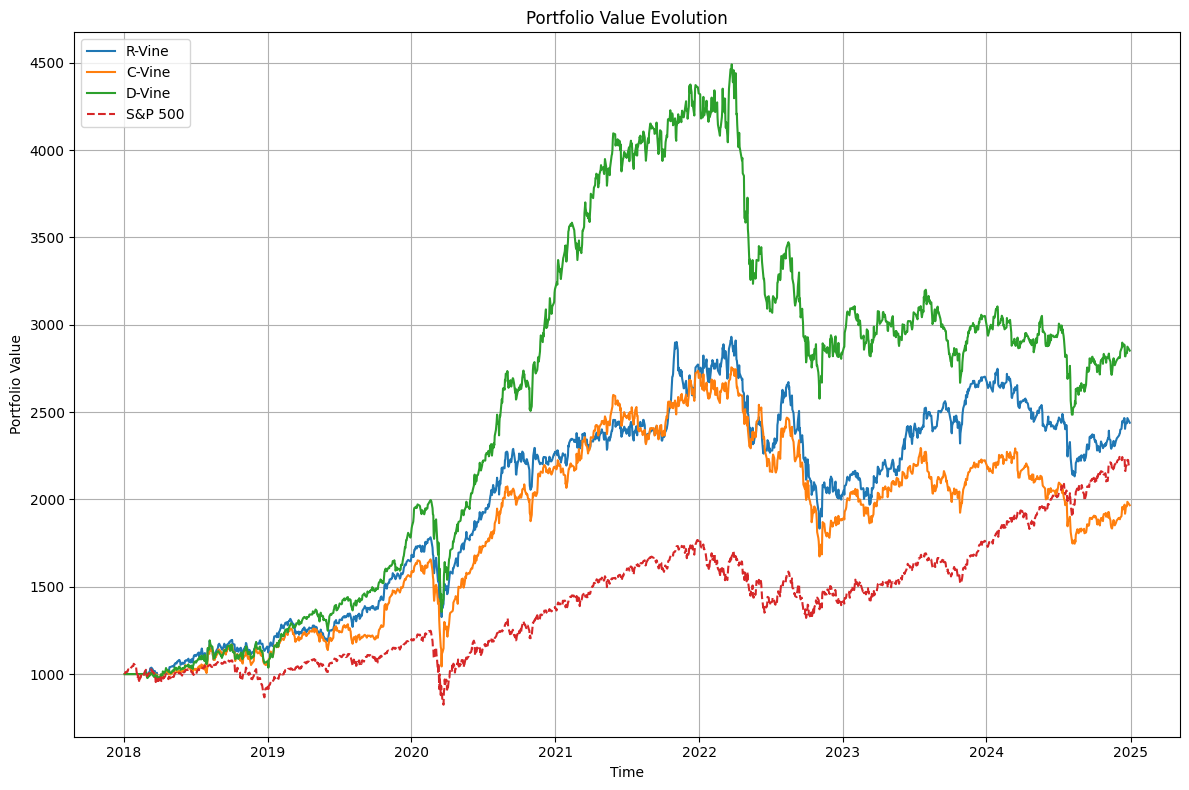

,Sharpe Ratio,Max Drawdown (%),Total Return (%)
Portfolio,,,
R-Vine,0.67,-37.46,143.79
C-Vine,0.5,-39.28,96.38
D-Vine,0.74,-44.66,185.52
S&P 500,Ticker ^GSPC 0.53 dtype: float64,-33.92,117.72


In [ ]:
# whiweights=garchcopulaopt_rolling(trad_returns,30)
copula_types = ['R-Vine', 'C-Vine', 'D-Vine']
trad_performance = plot_portfolio_value(weights, trad_returns, copula_types, n, sp500_returns)

In [ ]:
crypto_returns.mean()

,0
Ticker,
BTC-USD,0.074931
ETH-USD,0.057488
PIVX-USD,-0.139569
UNO-USD,-0.148203
XRP-USD,-0.005879
XVG-USD,-0.098559


In [ ]:
weight_crypto=garchcopulaopt_rolling(crypto_returns,n)



/usr/local/lib/python3.11/dist-packages/copulas/multivariate/vine.py:334: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sampled[current] = new_x
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_zeros_py.py:798: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = _zeros._brentq(f, a, b, xtol, rtol, maxiter, args, full_output, disp)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_zeros_py.py:798: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r = _zeros._

ValueError: f(a) and f(b) must have different signs

In [ ]:
#portfolio evolution for crypto portfolio
copula_types = ['R-Vine', 'C-Vine', 'D-Vine']
plot_portfolio_value(weight_crypto, crypto_returns, copula_types,n)

In [ ]:
combined_portfolio= pd.concat([trad_returns, crypto_returns], axis=1)


In [ ]:

combined_portfolio = combined_portfolio.dropna()

In [ ]:
columns_to_remove = ['PIVX-USD', 'UNO-USD', 'XRP-USD', 'XVG-USD']
combined_portfolio = combined_portfolio.drop(columns=columns_to_remove, errors='ignore')

In [ ]:
weight_combined=garchcopulaopt_rolling(combined_portfolio,n)
copula_types = ['R-Vine', 'C-Vine', 'D-Vine']



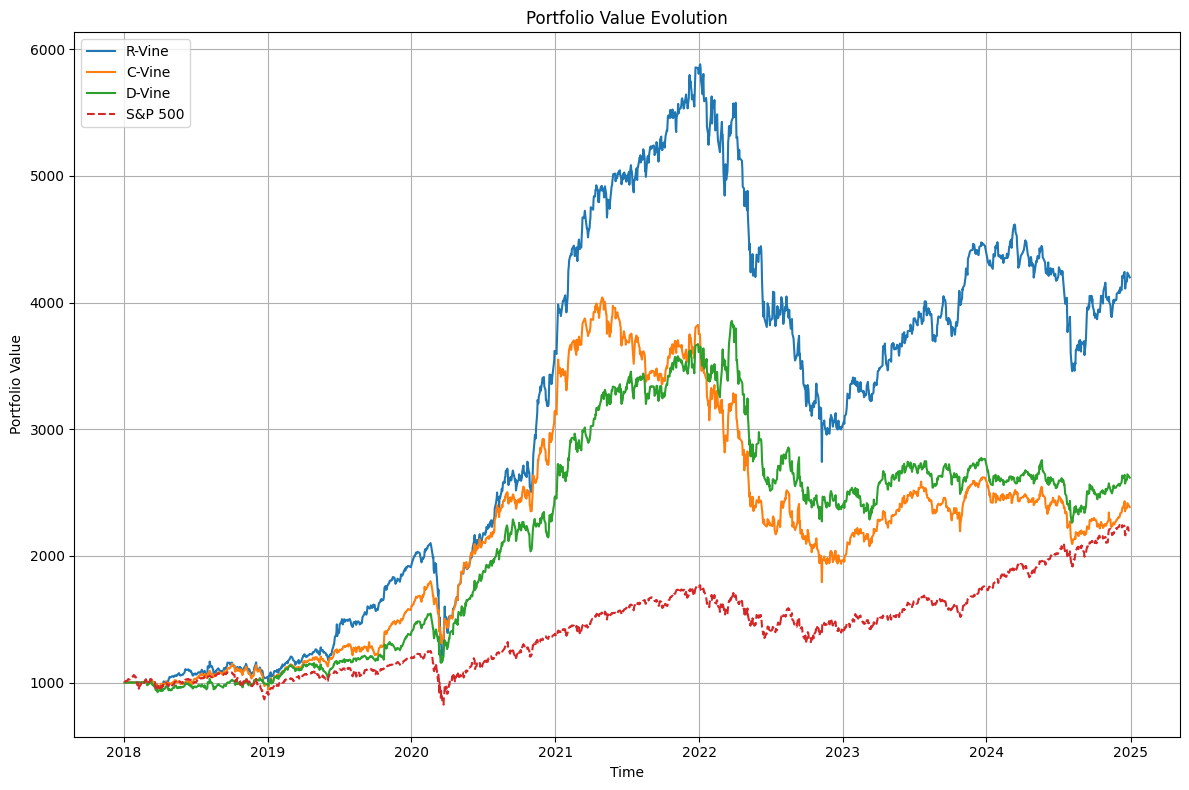

,Sharpe Ratio,Max Drawdown (%),Total Return (%)
Portfolio,,,
R-Vine,0.86,-53.38,319.32
C-Vine,0.58,-55.63,138.62
D-Vine,0.67,-41.38,162.48
S&P 500,Ticker ^GSPC 0.53 dtype: float64,-33.92,117.72


In [ ]:
combined_performance=plot_portfolio_value(weight_combined, combined_portfolio, copula_types,n, sp500_returns)


In [ ]:
# Download S&P 500 data
sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1d')['Close']
sp500_returns = np.log(sp500 / sp500.shift(1)) * 100
sp500_returns = sp500_returns.dropna()

In [ ]:
# Crypto portfolio comparison with S&P 500
copula_types = ['R-Vine', 'C-Vine', 'D-Vine']
crypto_performance = plot_portfolio_value(weight_crypto, crypto_returns, copula_types, n, sp500_returns)

In [ ]:
def plot_performance_comparison(trad_performance, crypto_performance, combined_performance):
    """
    Create bar charts comparing the performance metrics across different portfolios
    """
    # Combine all performance dataframes
    all_performance = pd.concat([
        trad_performance.assign(Portfolio_Type='Traditional'),
        crypto_performance.assign(Portfolio_Type='Cryptocurrency'),
        combined_performance.assign(Portfolio_Type='Combined')
    ])

    # Create a figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Sharpe Ratio
    sns.barplot(x='Portfolio', y='Sharpe Ratio', hue='Portfolio_Type', data=all_performance, ax=axes[0])
    axes[0].set_title('Sharpe Ratio Comparison')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

    # Plot Max Drawdown
    sns.barplot(x='Portfolio', y='Max Drawdown (%)', hue='Portfolio_Type', data=all_performance, ax=axes[1])
    axes[1].set_title('Maximum Drawdown Comparison')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

    # Plot Total Return
    sns.barplot(x='Portfolio', y='Total Return (%)', hue='Portfolio_Type', data=all_performance, ax=axes[2])
    axes[2].set_title('Total Return Comparison')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot performance comparison
plot_performance_comparison(trad_performance, crypto_performance, combined_performance)